In [8]:
import nltk, re, math, random
from bs4 import BeautifulSoup

In [10]:
from curses.ascii import isdigit
from nltk.corpus import cmudict
import numpy as np

In [5]:
# coding: utf-8

### Possible Message Keys ###

keys = ['X-GM-THRID', 'X-Gmail-Labels', 'Delivered-To', 'Received', 'X-Received', 'Return-Path', 'Received', 
'Received-SPF', 'Authentication-Results', 'DKIM-Signature', 'DomainKey-Signature', 'Received', 'Date', 
'From', 'Reply-To', 'To', 'Message-ID', 'Subject', 'MIME-Version', 'Content-Type', 'x-mid', 'x-job', 
'Feedback-ID', 'x-rpcampaign', 'x-orgId', 'List-Unsubscribe']


### Imports ###

import mailbox
import os
import re

### Functions ###

#Downloads the messages, stops recursing when it reaches html
def showPayload(msg):
    ret = ""
    ignore = ["<html", "<div", "<!DOCT", "<head"]
    stop = False
    
    payload = msg.get_payload()
    global nones
    
    if payload is not None:              
        if msg.is_multipart():
            for subMsg in payload:
                data, stop = showPayload(subMsg)
                
                if not stop:
                    ret += data
                else:
                    break
        else:
            if any(x in payload for x in ignore): #if this is the start of html bullshit, just stop parsing the message
                ret = ""
                stop = True
            return payload, stop
    else:
        nones += 1
        
    return ret, stop


#Dict[candidate_name] -> list of email dicts with keys: Body, From, Subject, Date, Candidates party
def get_cleaned_data():

    directory = os.getcwd() + "/Takeout/Mail"
    files = os.listdir(directory)

    candidate_dict = {}

    for candidate in files:
        mbox = mailbox.mbox(directory + "/" + candidate)

        candidate_name = candidate.split("-")[1][:-5]
        candidate_party = candidate.split("-")[0]
        messages = []

        for message in mbox:
            mini_dict = {}
            body, _ = showPayload(message)

            #This is where we add keys for the messages, so if some data is missing that you want add it here.
            mini_dict["body"] = body
            mini_dict["From"] = message["From"]
            mini_dict["Subject"] = message["Subject"]
            mini_dict["Date"] = message["Date"]
            mini_dict["Party"] = candidate_party

            messages.append(mini_dict)

        candidate_dict[candidate_name] = messages
    return candidate_dict


## Sage's Stuff

### Visualization Code

In [7]:
%matplotlib inline
#matplotlib.use('Agg')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


data = get_cleaned_data()

candidates = list(data.keys())
#candidates = ["Trump", "Clinton", "Sanders"]


weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
month_to_num = {"Jan" : 1, "Feb" : 2, "Mar" : 3, "Apr" : 4, "May" : 5, "Jun" : 6, "Jul" : 7, 
               "Aug" : 8, "Sep" : 9, "Oct" : 10, "Nov" : 11, "Dec" : 12}
arr = np.ndarray(shape=(len(candidates),len(weekdays)), dtype=int, order='F')


# Takes a dictionary, and a set of keys that you want the dictionary values in order of
# {"A" : 100, "C" : 50, "B" : 75}, ["A","B","C"] -> [100, 75, 50]
# Assumes values are integers and inserts 
def dict_to_ordered_list(my_dict, order):
    lst = []
    for key in order:
        # Need this If-statement since not all candidates email every day of 
        # the week and defaultdicts are a pain in the ass to initialize
        if key in my_dict:
            lst.append(my_dict[key])
        else:
            lst.append(0)

    return lst

# Gets counts for each day of the week
def weekday_histogram(data, candidate):
    candidate_data = data[candidate]
    weekday_count = defaultdict(int) #defaultdict so all values are initialized for incrementation
        
    for email in candidate_data:
        day = re.match("(\w+),", email["Date"]).group(1) #strip out the weekday from form Day, ...
        weekday_count[day] += 1
        
        
    return dict(weekday_count) #convert to normal dict from defaultdict

#gets the counts for each day of the month cummulatively so the data isn't sparse
def month_histogram(data):
    month_day_data = defaultdict(int) #defaultdict so all values are initialized for incrementation
    
    for candidate in candidates:
        candidate_data = data[candidate]

        for email in candidate_data:
            print(email["Date"])
            day = re.search(r", (\d+) (\w+)", email["Date"])#strip out the weekday from form Day, ...
            print("2016-",month_to_num[day.group(2)], "-", day.group(1), sep="")
            
            month_day_data
            #weekday_count[day] += 1
        
        
    return dict(month_day_data) #convert to normal dict from defaultdict

### Weekday Frequency

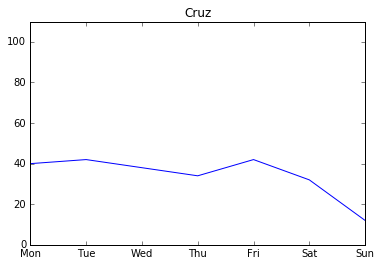

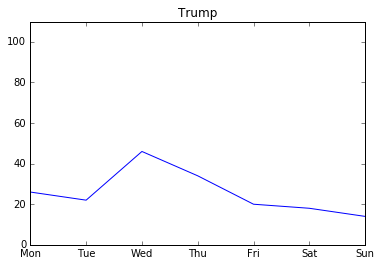

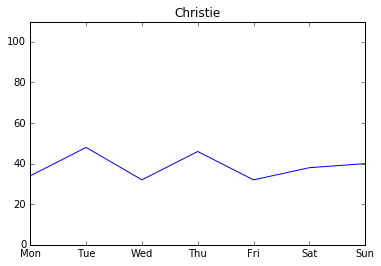

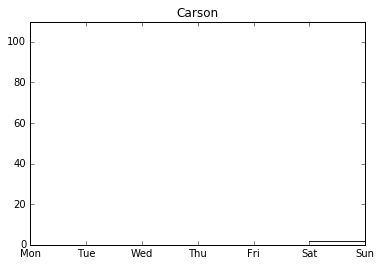

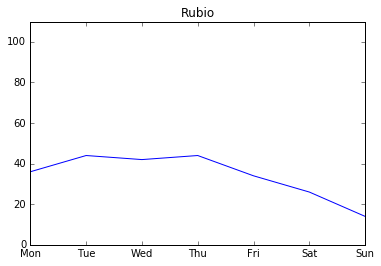

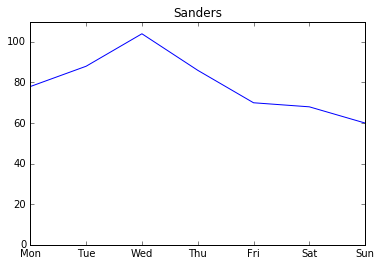

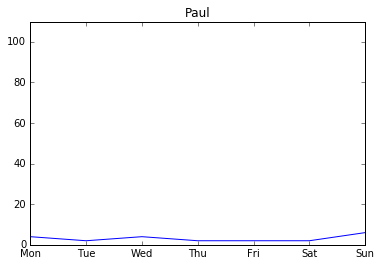

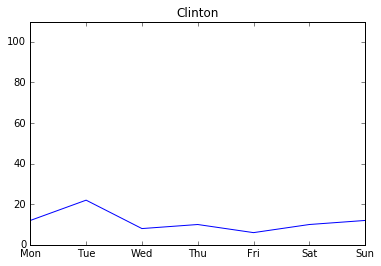

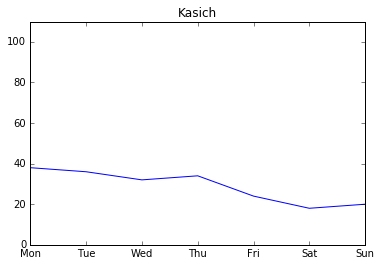

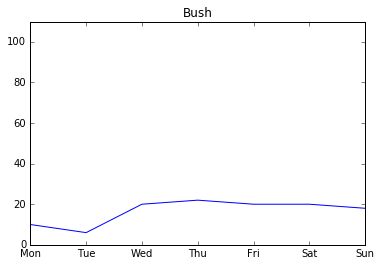

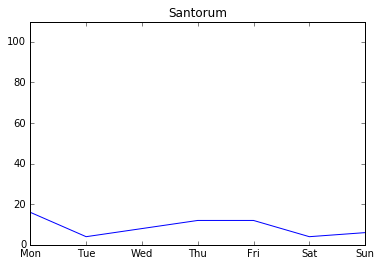

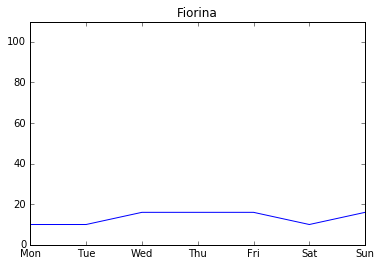

In [8]:
temp_candidate_data = []

for idx, candidate in enumerate(candidates):
    day_of_the_week_data = weekday_histogram(data, candidate)
    temp_candidate_data.append(dict_to_ordered_list(day_of_the_week_data, weekdays))
    plot_me = pd.Series(day_of_the_week_data, index=weekdays)
    plot_me.ix(weekdays)

    # Plot individual graphs
    plot_me.plot(x='Weekday', y='y', title=candidate).set_ylim(0,110)
    #add figure and plot it
    plt.show()

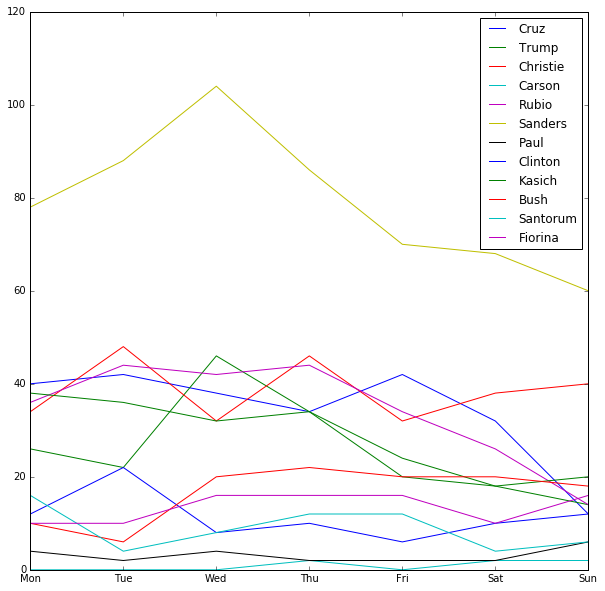

In [9]:
#multicandidate graph
arr = list(zip(*temp_candidate_data)) #need to re-orient the arrays
df = pd.DataFrame(arr, index=weekdays, columns=candidates)
df.plot(figsize=(10,10)); plt.show()

### Mikey's Stuff

In [25]:
d = cmudict.dict()

def url_count(bodies):
  # COUNT THE NUMBER OF URLS IN THE BODY OF THE EMAILS
  urls = re.findall(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' '.join(bodies))
  return len(urls)

def clean_text(text):
  # REMOVES WORDS WITH DIGITS IN THEM
  clean = re.sub(r'\w*\d\w*', '', text).strip()
  clean = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', clean)

  #clean = re.sub('<[^>]*>', '', clean)
  soup = BeautifulSoup(clean, 'lxml')
  clean = soup.get_text()

  return clean

def nsyl(word):
  if word.lower() in d:
    return max([len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]])
  else:
    return 0

def extract_features(body, raw=False):
  feat = {}
  sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
  word_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
  clean_body = clean_text(body)

  tokens = nltk.word_tokenize(clean_body.lower())
  words = word_tokenizer.tokenize(clean_body.lower())
  sentences = sentence_tokenizer.tokenize(clean_body)
  vocab = set(words)
  words_per_sentence = np.array([len(word_tokenizer.tokenize(s)) for s in sentences])
  syllables_per_word = sum([nsyl(w) for w in words]) / len(words)

  urls = re.findall(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', body)

  feat['url_count'] = len(urls)
  feat['avg_words_sent'] = int(math.floor(words_per_sentence.mean()/5))*5
  feat['sent_len_variation'] = int(math.floor(words_per_sentence.std()/5))*5
  feat['lex_diversity'] = round( len(vocab) / float(len(words)), 4)
  feat['avg_sylla_word'] = round(syllables_per_word, 4) # Maybe 2 or 3
  feat['reading_score'] = int( math.floor( (206.835 - (1.015 * words_per_sentence.mean()) - (84.6 * syllables_per_word))/5 ))*5

  if raw:
    return (206.835 - (1.015 * words_per_sentence.mean()) - (84.6 * syllables_per_word))

  return feat

def classify_candidates(candidate_bodies):
  ndx = len(candidate_bodies)//3
  random.shuffle(candidate_bodies)

  feat_label = [(extract_features(tup[0]), tup[1]) for tup in candidate_bodies]

  test_set, train_set = feat_label[:ndx], feat_label[ndx:]

  classifier = nltk.NaiveBayesClassifier.train(train_set)
  #print('ACCURACY: %f'%nltk.classify.accuracy(classifier, test_set))
  return nltk.classify.accuracy(classifier, test_set)

In [32]:
clean_data = get_cleaned_data()
candidates = list(clean_data.keys())
#print(candidates)
#print('')

candidate_bodies = []
candidate_url_ratios = []
candidate_vocab_depth = []
candidate_read_ease = []
candidate_froms = []
for candidate in candidates:
    emails = clean_data[candidate]
    #print(candidate)
    #print('TOTAL NUMBER OF EMAILS: %d'%len(emails))

    subjects = []
    bodies = []
    froms = []
    for email in emails:
        subjects.append(email['Subject'])
        bodies.append(email['body'])
        froms.append(email['From'])

        if len(email['body']) > 0:
            candidate_bodies.append((email['body'],candidate))


    # NUMBER OF URLS FOUND IN EMAILS
    num_urls = url_count(bodies)
    #print('URL COUNT: %d'%num_urls)
    #print('URL TO EMAIL RATIO: %f'%(num_urls/len(emails)))
    candidate_url_ratios.append((candidate, num_urls/len(emails)))

    # NUMBER OF UNIQUE FORWARDING EMAIL ADDRESSES
    #print('UNIQUE FROMS:')
    #print(set(froms))
    #print('UNIQUE FROMS: %d'%(len(set(froms))))
    candidate_froms.append((candidate,len(set(froms))))

    score = extract_features(' '.join(bodies), True)
    candidate_read_ease.append((candidate, score))


    # MAYBE CHANGE THE ORDERING, TOKENIZE THE WORDS AND THEN REMOVE THE WEIRD INSTANCES
    subjects = clean_text(' '.join(subjects))
    bodies = clean_text(' '.join(bodies))

    subject_tokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(subjects)
    subject_words = [word.lower() for word in subject_tokens if word not in nltk.corpus.stopwords.words('english')]
    subject_freq = nltk.FreqDist(subject_words)
    #print('SUBJECT FREQ WORDS:')
    #print(subject_freq.most_common(50))


    body_tokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(bodies)
    body_words = [word.lower() for word in body_tokens if word not in nltk.corpus.stopwords.words('english')]
    body_freq = nltk.FreqDist(body_words)
    #print('BODY FREQ WORDS:')
    #print(body_freq.most_common(50))


    #print('UNIQUE WORDS: %d'%len(set(body_words)))
    #print('TOTAL WORDS: %d'%len(body_words))
    #print('VOCABULARY DEPTH: %f'%( math.log10(len(set(body_words)))/math.log10(len(body_words)) ))
    candidate_vocab_depth.append((candidate, math.log10(len(set(body_words)))/math.log10(len(body_words))))

In [12]:
print('UNIQUE FROMS:\n %s' % sorted(candidate_froms, key=lambda x: x[1]))

UNIQUE FROMS:
 [('Carson', 2), ('Fiorina', 5), ('Paul', 7), ('Bush', 11), ('Trump', 13), ('Clinton', 14), ('Santorum', 14), ('Sanders', 16), ('Kasich', 19), ('Rubio', 33), ('Cruz', 33), ('Christie', 41)]


In [13]:
print('URL RATIOS:\n %s' % sorted(candidate_url_ratios, key=lambda x: x[1]))

URL RATIOS:
 [('Bush', 1.9827586206896552), ('Kasich', 2.01980198019802), ('Clinton', 2.55), ('Rubio', 2.7916666666666665), ('Trump', 2.8666666666666667), ('Paul', 3.0), ('Sanders', 3.5342960288808665), ('Santorum', 3.6129032258064515), ('Fiorina', 4.361702127659575), ('Cruz', 4.391666666666667), ('Christie', 5.17037037037037), ('Carson', 9.0)]


In [15]:
print('VOCAB DEPTH:\n %s' % sorted(candidate_vocab_depth, key=lambda x: x[1]))

VOCAB DEPTH:
 [('Christie', 0.7167128269451892), ('Sanders', 0.7184732546232202), ('Rubio', 0.7345965826758764), ('Cruz', 0.7433054424297223), ('Trump', 0.7443400098404391), ('Paul', 0.7503217824682225), ('Clinton', 0.758535850389818), ('Kasich', 0.7772517766069418), ('Santorum', 0.7801292186007066), ('Carson', 0.8039743464943653), ('Fiorina', 0.8304015815074304), ('Bush', 0.836036368333285)]


In [16]:
print('READING EASE SCORE:\n %s' % sorted(candidate_read_ease, key=lambda x: x[1], reverse=True))

READING EASE SCORE:
 [('Carson', 82.543996213292644), ('Bush', 78.291370235587081), ('Fiorina', 69.43018352622191), ('Clinton', 65.226530855013621), ('Christie', 63.318769359444971), ('Rubio', 63.23277311426952), ('Santorum', 58.917869069487537), ('Trump', 58.782123296222494), ('Paul', 57.77066800076237), ('Cruz', 57.656644217440686), ('Sanders', 56.547949945639004), ('Kasich', 55.806307312933427)]


In [33]:
acc_sum = 0.0
for i in range(5):
    acc_sum += classify_candidates(candidate_bodies)
print('AVERAGE ACCURACY: %f'%(acc_sum/5))
print('')

AVERAGE ACCURACY: 0.750146



## Sam's Stuff

In [21]:
canDict = get_cleaned_data()

In [22]:
def clean_doc(doc):
    doc = doc.replace('=C2=A0',' ')
    doc = doc.replace('-=3D-=3D-', '')
    doc = doc.replace('=E2=80=9C', '')
    doc = doc.replace('=E2=80=9D', '')
    doc = ''.join(x for x in doc if ord(x) < 128)
    doc = doc.replace('=', '')
    return doc
    return [x.replace('\n', '').lower() for x in doc.split(' ')]

In [23]:
money = re.compile(r'\$(.*)')

In [24]:
donate_words = ['donate', 'contribute']
def asks_for_donation(doc):
    clean = clean_doc(doc)
    if any(wd in clean for wd in donate_words):
        return True
    #if any('donate' in cl for cl in clean):
    #    return True
    for word in clean:
        if money.match(word):
            return True
    return False

In [25]:
emails = [canDict[candidate] for candidate in canDict.keys()]
subject_words_donate = list()
subject_words_not = list()

In [26]:
for email in emails:
    for e in email:
        if asks_for_donation(e['body']):
            subject_words_donate += e['Subject'].split()
        else:
            subject_words_not += e['Subject'].split()

In [27]:
freq_don = nltk.FreqDist(w.lower() for w in subject_words_donate)
freq_non = nltk.FreqDist(w.lower() for w in subject_words_not)

In [28]:
def in_freq(line, boolean):
    line = line.split()
    most_common_don = freq_don.most_common(40)
    most_common_non = freq_non.most_common(40)
    if boolean:
        mc = most_common_don
    else:
        mc = most_common_non
        
    mc = [word[0] for word in mc[10:]]
    #print(mc)
    count = 0
    for word in line:
        if word in mc:
            count += 1
    #print(count)
    if count <= 1:
        return 'low'
    if count >= 3: 
        return 'high'
    return 'med'

In [29]:
email_feats = []
to_ap = ()
for candidate in canDict.keys():
    for email in canDict[candidate]:
        #email_feats.append(asks_for_donation(email['body']))
        feats = {}
        feats['cand'] = candidate
        feats['don_words'] = in_freq(email['Subject'], True)
        feats['non_words'] = in_freq(email['Subject'], False)
        to_ap = (feats, asks_for_donation(email['body']))
        email_feats.append(to_ap)

In [30]:
random.shuffle(email_feats)

In [31]:
test_cutoff = int(len(email_feats) / 4)
train, test = email_feats[0:test_cutoff * 3], email_feats[test_cutoff * 3:]
classifier = nltk.NaiveBayesClassifier.train(train)

In [32]:
print("Accuracy: ",nltk.classify.accuracy(classifier,test))

Accuracy:  0.7857142857142857
